In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as la
from enum import Enum
from numpy import random
%matplotlib inline

np.set_printoptions(formatter={'float': lambda x: '{:.3}'.format(x)})

In [2]:
class ProgressBar(object):
    
    def __init__(self, total, prefix='', suffix='', decimals=1, length=100, fill='█'):
        """
        Creates terminal progress bar instance.
        @params:
            total      - Required  : total iterations (Int)
            prefix     - Optional  : prefix string (Str)
            suffix     - Optional  : suffix string (Str)
            decimal    - Optional  : positive number of decimals in percent complete (Int)
            length     - Optional  : character length of bar (Int):
            fill       - Optional  : bar fill character (Str)
        """
        self.total = total
        self.prefix = prefix
        self.suffix = suffix
        self.decimals = decimals
        self.length = length
        self.fill = fill


    def print_bar(self, iteration):
        """
        Updates progress bar status.
        @params:
            iteration  - Required  : current iteration (Int)
        """
        percent = ("{0:." + str(self.decimals) + "f}").format(
                        100 * (iteration / float(self.total)))
        filled_length = int(self.length * iteration // self.total)
        bar = self.fill * filled_length + '-' * (self.length - filled_length)

        print('\r{} |{}| {}% {}'.format(self.prefix, bar, percent, self.suffix), end='\r')

        # print a new line on complete
        if iteration == self.total:
            print()


class Id(object):
    """
    ID generator - a singleton class.

    Example:
        ID = Id()
        Id.get()
    """

    class __Id:

        def __init__(self):
            self.generator = self.id_gen()

        def id_gen(self):
            id_ = 0
            while True:
                yield id_
                id_ += 1

        def get(self):
            return next(self.generator)
        
        def reset(self):
            self.generator = self.id_gen()

    instance = None

    def __new__(cls):
        if not Id.instance:
            Id.instance = Id.__Id()
        return Id.instance

    def __getattr__(self, name):
        return getattr(self.instance, name)

    def __setattr__(self, name):
        return setattr(self.instance, name)


TOLERANCE = 1e-15


def vec3D(x, y, z):
    return np.array([x, y, z])

def normalize(x):
    norm = la.norm(x)
    return x / norm if norm > TOLERANCE else vec3D(0.,0.,0.)

def to_log_scale(lin_scaled):
    return 10 * np.log10(lin_scaled) if lin_scaled > TOLERANCE else -np.inf

def to_lin_scale(log_scaled):
    return np.exp(log_scaled / 10)

def power(amplitude):
    return np.abs(amplitude) ** 2


## Geometry

**Plane**  
Projection point of RX:
$$ \mathcal{Pr}[\vec{r}] = \vec{r}_P = \vec{r}_{RX} - 2 (\vec{r}_{RX} - \vec{r}_0, \vec{n}) \vec{n} $$

Intersection or reflection point:
$$ \mathcal{In}[\vec{r}] = \vec{r}_I = \vec{r}_{TX} - 
\frac{(\vec{r}_{TX} - \vec{r}_0, \vec{n})}{(\vec{D_1}, \vec{n})} \vec{D_1} $$

where direction of grazing ray $\vec{d_1} = \vec{D_1} / D_1$:
$$ \vec{D_1} = \vec{r}_P - \vec{r}_{TX} = \vec{r}_{RX} - \vec{r}_{TX} - 2 (\vec{r}_{RX} - \vec{r}_0, \vec{n})$$

Direction of reflected ray $\vec{d_2} = \vec{D_2} / D_2$:
$$ \vec{D_2} = \vec{r}_{RX} - \vec{r}_I = \vec{r}_{RX} - \vec{r}_{TX} + 
\frac{(\vec{r}_{TX} - \vec{r}_0, \vec{n})}{(\vec{D_1}, \vec{n})} \vec{D_1}$$


In [26]:
class Shape(object):

    def get_normal(self, surface_point):
        pass
    
    def intersect(self, start, direction):
        return np.inf


class Plane(Shape):
    
    TOLERANCE = 1e-6
    
    def __init__(self, init_point, normal, reflection=1.+0.j):
        self.init_point = init_point
        self.normal = normal
        self.reflection = reflection


    def get_normal(self, surface_point):
        return self.normal


    def intersect(self, start, direction):

        denom = np.dot(direction, self.normal)
        if np.abs(denom) < Plane.TOLERANCE:
            return np.inf

        tau = np.dot(self.init_point - start, self.normal) / denom
        if tau < 0:
            return np.inf

        return tau


    def project(self, point):
        
        return point - 2 * np.dot(point - self.init_point, self.normal) * self.normal


    def reflect(self, start, end):

        dir_grazing = self.project(end) - start
        dir_grazing = normalize(dir_grazing)

        tau = self.intersect(start, dir_grazing)
        if tau == np.inf:
            return None

        intersection = start + tau * dir_grazing
        dir_reflected = end - intersection
        dir_reflected = normalize(dir_reflected)

        return intersection, dir_grazing, dir_reflected

## Ray and RayTree definition

In [4]:
class Ray(object):

    c = 299792458. # speed of light, in mps

    class Type(Enum):
        PRIMARY = 0
        REFLECTED = 1
        REFRACTED = 2
    
    def __init__(self, start, direction, k, r_atts=1.+0.j, path_len=0., type_=Type.PRIMARY):

        self.id = Id().get()
        self.type = type_

        # Geometrical properties
        self.start = start
        self.direction = direction
        self.end = None
        self.length = -1

        # Propagation parameters
        self.r_atts = r_atts
        self.k = k
        self.path_len = path_len
        
        self.delay = 0.
        self.att = 0.j

    def __str__(self):
        string = '<{}({}) start={} end={} dir={} len={:>4.3}; k={:>4.3}, A={:>4.3f}, delay={:>4.3}>'
        return string.format(self.type.name, self.id, self.start, self.end, 
                             self.direction, self.length, self.k, to_log_scale(np.abs(self.att) ** 2), self.delay)


    def set_end(self, end):
        self.end = end
        self.length = la.norm(self.end - self.start)


    def attenuation(self, time=0., rspeed=None):
        full_len = self.length + self.path_len
#         print('[attenuation]', full_len, self.r_atts)
        self.att = .5 / (self.k * full_len) * np.exp(-1j * self.k * full_len) * self.r_atts
        return self.att

    def delay(self):
        self.delay = (self.length + self.path_len) / c
        return self.delay

    def doppler_shift(self, rspeed):
        return .5 / np.pi * self.k * np.dot(self.direction, rspeed)



class RayNode(object):
    
    def __init__(self, ray, parent=None):

        self.ray = ray
        self.parent = parent
        self.reflected = None
        self.refracted = None

        self.id = ray.id
        self.depth = parent.depth + 1 if parent else 0


    def __str__(self):
        reflected_id = str(self.reflected.ray.id) if self.reflected else '.'
        refracted_id = str(self.refracted.ray.id) if self.refracted else '.'
        self_id = str(self.ray.id)
        return '({})<({})>({})'.format(refracted_id, self_id, reflected_id)

            
    def view(self):
        refracted_view = self.refracted.view() if self.refracted else '.'
        reflected_view = self.reflected.view() if self.reflected else '.'
        return '[{}]<({})>[{}]'.format(refracted_view, str(self.ray.id), reflected_view)


# TODO: raise exception if adding to a leave
class RayTree(object):
    
    def __init__(self, ray, leave=False):

        self.root_ = RayNode(ray)
        self.current_ = self.root_

        self.rays_ = {ray.id: ray}
        self.levels_ = {0: ray.id}
        self.leaves_ = list()
        if leave:
            self.leaves_.append(ray.id)


    def __str__(self):
        return self.root_.view()


    def add_ray(self, ray, leave=False):
    
        if ray.type is Ray.Type.REFLECTED:
            self.current_.reflected = RayNode(ray, self.current_)

        elif ray.type is Ray.Type.REFLECTED:
            self.current_.refracted = RayNode(ray, self.current_)

        self.rays_[ray.id] = ray
        self.levels_[self.current_.depth] = ray.id
        if leave:
            self.leaves_.append(ray.id)


    def get_reflected(self):
        self.current_ = self.current_.reflected
        return self

    def get_refrected(self):
        self.current_ = self.current_.refracted
        return self

    def get_leaves(self):
        return [self.rays_[ray_id] for ray_id in self.leaves_]

    def get_rays(self):
        return self.rays_.values()

## Radio Ray Tracer

In [31]:
class RadioRayTracer(object):
    
    def __init__(self, scene, wavelen, k):
        self.scene = scene
        self.wavelen = wavelen
        self.k = k


    # TODO: handle checking intersections
    def run(self, tx_pos, rx_pos):

        forest = []

        # Compute a line-of-sight component
        ray = Ray(tx_pos, normalize(rx_pos - tx_pos), self.k)
        ray.set_end(rx_pos)
        ray.attenuation()

        forest.append(RayTree(ray, leave=True))

#         Compute 1-reflected components
        for shape in self.scene:

            output = shape.reflect(tx_pos, rx_pos)
            if not output:
                continue
            intersection, dir_grazing, dir_reflected = output

            ray_primary = Ray(tx_pos, dir_grazing, self.k)
            ray_primary.set_end(intersection)
            path_length = ray_primary.length

            ray_reflected = Ray(intersection, dir_reflected, self.k, 
                                r_atts=shape.reflection, path_len=path_length, 
                                type_=Ray.Type.REFLECTED)
            ray_reflected.set_end(rx_pos)
            ray_reflected.attenuation()

            tree = RayTree(ray_primary)
            tree.add_ray(ray_reflected, leave=True)

            forest.append(tree)

        return forest


In [53]:
class KRayPathloss(object):
    
    c = 299792458. # speed of light, in mps
    
    def __init__(self, scene, freq):
        self.scene = scene
        
        self.wavelen = KRayPathloss.c / freq
        self.k = 2 * np.pi / self.wavelen
        
        self.ray_forets_ = None
        self.ray = None


    def compute(self, tx_pos, rx_pos, time=0.):
        
        attenuation = 0.j
        tracer = RadioRayTracer(self.scene, self.wavelen, self.k)
        
        self.ray_forets_ = tracer.run(tx_pos, rx_pos)

        for ray_tree in self.ray_forets_:
            
            for ray in ray_tree.get_leaves():
                attenuation += ray.att
#                 print(ray)

        return attenuation



class KRayWrapper(object):
    
    def __init__(self, scene, freq):
        self.kray = KRayPathloss(scene, freq)


    def _to_1darray(self, x):
        
        if isinstance(x, int) or isinstance(x, float):
            x = np.array([x])
        
        elif isinstance(x, list):
            x = np.array(x)
        
        return x


    def _to_output_type(self, att, out, log):
        
        if out == 'power':
            power = np.abs(att) ** 2
            return to_log_scale(power) if log else power

        if out == 'phase':
            return np.angle(att)

        if out == 'magnitude':
            return np.abs(att)

        if out == 'attenuation':
            return att


    def run(self, d, t=0., out='power', log=True):

        d = self._to_1darray(d)
        t = self._to_1darray(t)
        D, T = np.meshgrid(d, t)
        
        result = np.zeros(d.shape[0] * t.shape[0])        

        for i, d_i, t_i in zip(range(d.shape[0] * t.shape[0]), D.ravel(), T.ravel()):
            att = self.kray.compute(vec3D(0., 0., 5.), vec3D(d_i, 0., 5.), t_i)
            result[i] = self._to_output_type(att, out, log)

        return result.reshape((d.shape[0], t.shape[0]))

## Testing

In [39]:
class SceneBuilder(object):
    
    def empty():
        return []


    def one_plane():
        return [Plane(vec3D(0., 0., 0.), vec3D(0., 0., 1.), reflection=-1.+0.j)]

In [106]:
kray = KRayWrapper(SceneBuilder.one_plane(), 860e6)
pathloss = kray.run(np.array([1]))
pathloss

array([[-32.0]])

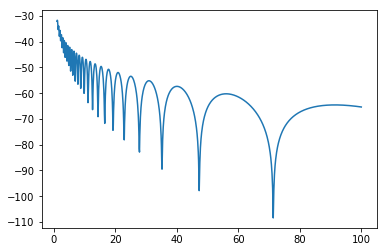

In [104]:
kray = KRayWrapper(SceneBuilder.one_plane(), 860e6)

distance = np.linspace(1, 100, 1000)
pathloss = kray.run(distance)

plt.figure()
plt.plot(distance, pathloss)
plt.show()

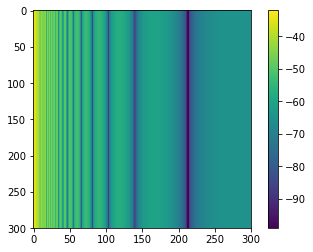

In [97]:
kray = KRayWrapper(SceneBuilder.one_plane(), 860e6)

distance = np.linspace(1, 100, 300)
time     = np.linspace(1, 20, 300)
pathloss = kray.run(distance, time)

plt.figure()
plt.imshow(pathloss)
plt.colorbar()
plt.show()

In [92]:
def two_ray_pathloss(distance, time=0., speed=0., tx_height=5., rx_height=5.):
    
    delta_height = np.abs(tx_height - rx_height)
    sigma_height = np.abs(tx_height + rx_height)
    
    d0 = (delta_height ** 2 + distance ** 2) ** 0.5
    d1 = (sigma_height ** 2 + distance ** 2) ** 0.5

    wavelen = 299792458 / 860e6
    k = 2 * np.pi / wavelen

    return (0.5 / k) ** 2 * np.abs(np.exp(-1j * k * d0) / d0 + 
                                   -1. * np.exp(-1j * k * d1) / d1  ) ** 2


def lin2db(value_linear):
    return 10 * np.log10(value_linear) if value_linear >= 1e-15 else -np.inf

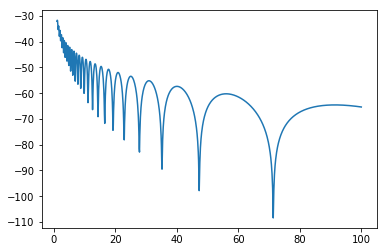

In [105]:
distance = np.linspace(1., 100, 1000)
pathloss = [lin2db(two_ray_pathloss(d)) for d in distance]

plt.figure()
plt.plot(distance, pathloss)
plt.show()